In [5]:
import wave
import pickle
import numpy as np
from sklearn.mixture import GaussianMixture
import librosa


In [2]:
!pip install auditok

     |████████████████████████████████| 1.9MB 11.5MB/s 
  Created wheel for auditok: filename=auditok-0.1.8-cp36-none-any.whl size=1482185 sha256=dfc40f1895ce6350a3e2d59fefc3e385eb142d61154071f791559694b69c5574
  Stored in directory: /root/.cache/pip/wheels/26/f4/04/faa57d1c5bb94911bf7a6fa5214088c7dd28ab3e6b9fbf6574
Successfully built auditok


In [7]:
from auditok import DataValidator, ADSFactory, DataSource, StreamTokenizer, BufferAudioSource, player_for

In [8]:
def extract_mfcc(signal, sr = 16000, n_mfcc=16, n_fft=256, hop_length=128, n_mels=40, delta_1=False, delta_2=False):
  mfcc = librosa.feature.mfcc(y=signal, sr=sr, n_mfcc=n_mfcc, n_fft=n_fft, hop_length=hop_length, n_mels=n_mels)
  if not (delta_1 or delta_2):
    return mfcc.T
  feat = [mfcc]
  if delta_1:
    mfcc_delta_1 = librosa.feature.delta(mfcc, order=1)
    feat.append(mfcc_delta_1)

  if delta_2:
    mfcc_delta_2 = librosa.feature.delta(mfcc, order=2)
    feat.append(mfcc_delta_2)

  return np.vstack(feat).T

In [9]:
def file_to_mfcc(filename, sr=16000, **kwargs):
  signal, sr = librosa.load(filename, sr=sr)
  return extract_mfcc(signal, sr, **kwargs)

In [10]:
class GMMClassifier():
  def __init__(self, models):
    self.models = models
  
  def predict(self, data):
    result = []
    for cls in self.models:
      llk = self.models[cls].score_samples(data)[0]
      llk = np.sum(llk)
      result.append((cls, llk))
    
    return sorted(result, key=lambda f: - f[1])

In [11]:
class ClassifierValidator(DataValidator):
  def __init__(self, classifier, target):
    self.classifier = classifier
    self.target = target
  
  def is_valid(self, data):
    r = self.classifier.predict(data)
    return r[0][0] == self.target

In [12]:
class VectorDataSource(DataSource):
  def __init__(self, data, scope=0):
    self.scope = scope
    self._data = data
    self._current = 0

  def read(self):
    if self._current >= len(self._data):
      return None
    
    start = self._current - self.scope
    if start < 0:
      start = 0
    end = self._current + self.scope + 1
    self._current += 1
    return self._data[start:end]

  def set_scope(self, scope):
    self.scope = scope
  
  def rewind(self):
    self._current = 0
    

In [13]:
"""
Size of audio window for which MFCC coefficients are calculated
"""
ANALYSIS_WINDOW = 0.02 # 0.02 second = 20 ms

"""
Step of ANALYSIS_WINDOW 
"""
ANALYSIS_STEP = 0.01 # 0.01 second overlap between consecutive windows

"""
number of vectors around the current vector to return.
This will cause VectorDataSource.read() method to return
a sequence of (SCOPE_LENGTH * 2 + 1) vectors (if enough
data is available), with the current vetor in the middle
"""
SCOPE_LENGTH = 10

"""
Number of Mel filters
"""
MEL_FILTERS = 40

"""
Number of MFCC coefficients to keep
"""
N_MFCC = 16

"""
Sampling rate of audio data
"""
SAMPLING_RATE = 16000

"""
ANALYSIS_WINDOW and ANALYSIS_STEP as number of samples
"""
BLOCK_SIZE = int(SAMPLING_RATE * ANALYSIS_WINDOW)
HOP_SIZE = int(SAMPLING_RATE * ANALYSIS_STEP)

"""
Compute delta and delta-delta of MFCC coefficients ?
"""
DELTA_1 = True
DELTA_2 = True

"""
Where to find data
"""
PREFIX = "data/train"

In [20]:
from google.colab import files

uploaded = files.upload()

for fn in uploaded.keys():
  print('User uploaded file "{name}" with length {length} bytes'.format(
      name=fn, length=len(uploaded[fn])))

Saving analysis_stream.wav to analysis_stream (1).wav
Saving breath.lst to breath (1).lst
Saving breath_1.wav to breath_1 (1).wav
Saving breath_2.wav to breath_2 (1).wav
Saving breath_3.wav to breath_3 (1).wav
Saving breath_4.wav to breath_4 (1).wav
Saving breath_5.wav to breath_5 (1).wav
Saving sewing_machine.lst to sewing_machine (1).lst
Saving sewing_machine.wav to sewing_machine (1).wav
Saving silence_1.wav to silence_1 (1).wav
Saving silence_2.wav to silence_2 (1).wav
Saving silence_3.wav to silence_3 (1).wav
Saving speech.lst to speech (1).lst
Saving speech_1.wav to speech_1 (1).wav
Saving speech_2.wav to speech_2 (1).wav
Saving speech_3.wav to speech_3 (1).wav
Saving speech_4.wav to speech_4 (1).wav
Saving speech_5.wav to speech_5 (1).wav
Saving whistle.lst to whistle (1).lst
Saving whistle_1.wav to whistle_1 (1).wav
Saving whistle_2.wav to whistle_2.wav
Saving whistle_3.wav to whistle_3 (1).wav
Saving whistle_4.wav to whistle_4 (1).wav
Saving whistle_5.wav to whistle_5 (1).wav


In [21]:
train_data = {}
train_data["silence"] = ["silence_1.wav", "silence_2.wav", "silence_3.wav"]
train_data["speech"]  = ["speech_1.wav", "speech_2.wav", "speech_3.wav", "speech_4.wav", "speech_5.wav"]
train_data["breath"]  = ["breath_1.wav", "breath_2.wav", "breath_3.wav", "breath_4.wav", "breath_5.wav"]
train_data["whistle"] = ["whistle_1.wav", "whistle_2.wav", "whistle_3.wav", "whistle_4.wav", "whistle_5.wav"]
train_data["wrapping_paper"] = ["wrapping_paper.wav"]
train_data["sewing_machine"] = ["sewing_machine.wav"]

models = {}

# build models
for cls in train_data:

    data = []
    for fname in train_data[cls]:
        data.append(file_to_mfcc( fname, sr=16000, n_mfcc=N_MFCC, n_fft=BLOCK_SIZE, hop_length=HOP_SIZE, n_mels=MEL_FILTERS, delta_1=DELTA_1, delta_2=DELTA_2))
    data = np.vstack(data)
    
    print("Class '{0}': {1} training vectors".format(cls, data.shape[0]))

    mod = GaussianMixture(n_components=10)
    mod.fit(data)
    models[cls] = mod

gmm_classifier = GMMClassifier(models)

# create a validator for each sound class
silence_validator = ClassifierValidator(gmm_classifier, "silence")
speech_validator = ClassifierValidator(gmm_classifier, "speech")
breath_validator = ClassifierValidator(gmm_classifier, "breath")
whistle_validator = ClassifierValidator(gmm_classifier, "whistle")
sewing_machine_validator = ClassifierValidator(gmm_classifier, "sewing_machine")
wrapping_paper_validator = ClassifierValidator(gmm_classifier, "wrapping_paper")


Class 'silence': 4254 training vectors
Class 'speech': 263 training vectors
Class 'breath': 696 training vectors
Class 'whistle': 399 training vectors
Class 'wrapping_paper': 1160 training vectors
Class 'sewing_machine': 418 training vectors


In [23]:
# transform audio stream to be analyzed into a sequence of MFCC vectors
# create a DataSource object using MFCC vectors
mfcc_data_source = VectorDataSource(data=file_to_mfcc("analysis_stream.wav",
                                                      sr=16000, n_mfcc=N_MFCC,
                                                      n_fft=BLOCK_SIZE, hop_length=HOP_SIZE,
                                                      n_mels=MEL_FILTERS, delta_1=DELTA_1,
                                                      delta_2=DELTA_2), scope=SCOPE_LENGTH)

In [24]:
# create a tokenizer
analysis_window_per_second = 1. / ANALYSIS_STEP

min_seg_length = 0.5 # second, min length of an accepted audio segment
max_seg_length = 10 # seconds, max length of an accepted audio segment
max_silence = 0.3 # second, max length tolerated of tolerated continuous signal that's not from the same class

tokenizer = StreamTokenizer(validator=speech_validator, min_length=int(min_seg_length * analysis_window_per_second),
                                max_length=int(max_seg_length * analysis_window_per_second),
                                max_continuous_silence= max_silence * analysis_window_per_second,
                                mode = StreamTokenizer.DROP_TRAILING_SILENCE)

In [26]:
# read all audio data from stream
wfp = wave.open("analysis_stream.wav")
audio_data = wfp.readframes(-1)
width = wfp.getsampwidth()
wfp.close()

# data as numpy array will be used to plot signal
fmt = {1: np.int8 , 2: np.int16, 4: np.int32}
signal = np.array(np.frombuffer(audio_data, dtype=fmt[width]), dtype=np.float64)

In [27]:
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.pylab as pylab
pylab.rcParams['figure.figsize'] = 24, 18

def plot_signal_and_segmentation(signal, sampling_rate, segments=[]):
    _time = np.arange(0., np.ceil(float(len(signal))) / sampling_rate, 1./sampling_rate )
    if len(_time) > len(signal):
        _time = _time[: len(signal) - len(_time)]
    
    pylab.subplot(211)

    for seg in segments:
        
        fc = seg.get("fc", "g")
        ec = seg.get("ec", "b")
        lw = seg.get("lw", 2)
        alpha = seg.get("alpha", 0.4)
        
        ts = seg["timestamps"]
        
        # plot first segmentation outside loop to show one single legend for this class
        p = pylab.axvspan(ts[0][0], ts[0][1], fc=fc, ec=ec, lw=lw, alpha=alpha, label = seg.get("title", ""))
        
        for start, end in ts[1:]:
            p = pylab.axvspan(start, end, fc=fc, ec=ec, lw=lw, alpha=alpha)
            
            
    pylab.legend(bbox_to_anchor=(0., 1.02, 1., .102), loc=3,
            borderaxespad=0., fontsize=22, ncol=2)
    
    pylab.plot(_time, signal)
    
    pylab.xlabel("Time (s)", fontsize=22)
    pylab.ylabel("Signal Amplitude", fontsize=22)
    pylab.show()

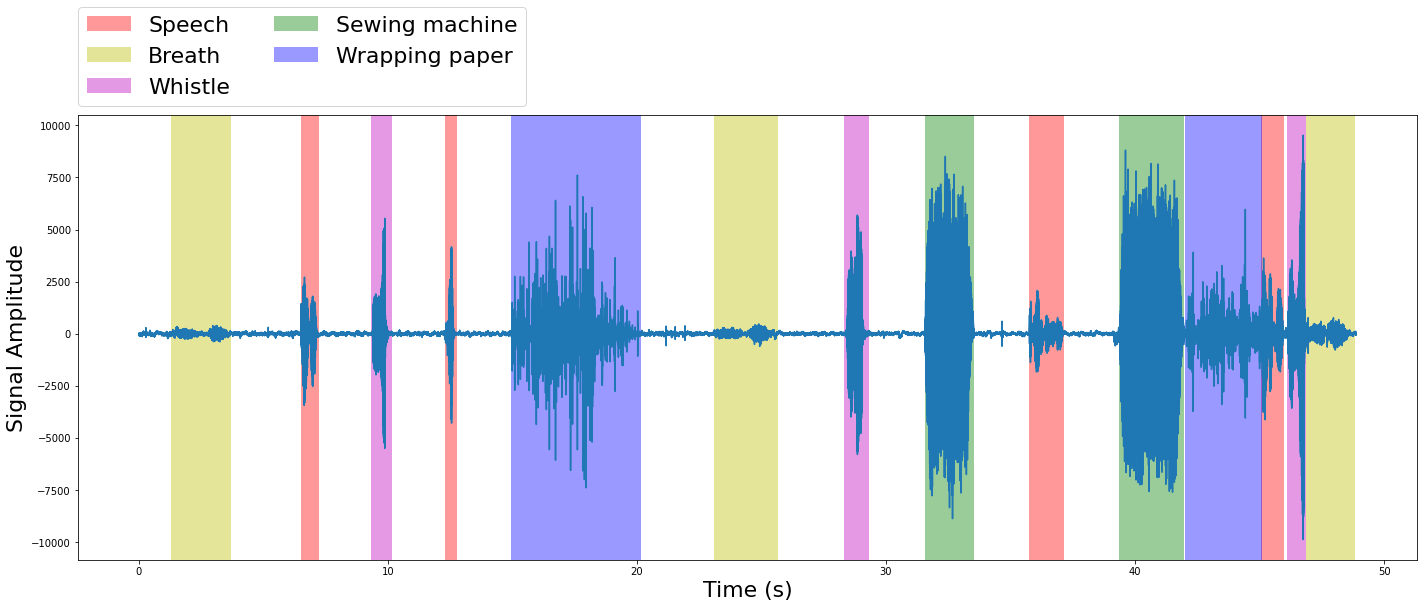

In [28]:
annotations = {}

ts = [line.rstrip("\r\n\t ").split(" ") for line in  open("speech.lst").readlines()]
ts = [(float(t[0]), float(t[1])) for t in ts]
annotations["speech"] = {"fc" : "r", "ec" : "r", "lw" : 0, "alpha" : 0.4, "title" : "Speech", "timestamps" : ts}

ts = [line.rstrip("\r\n\t ").split(" ") for line in  open("breath.lst").readlines()]
ts = [(float(t[0]), float(t[1])) for t in ts]
annotations["breath"] = {"fc" : "y", "ec" : "y", "lw" : 0, "alpha" : 0.4, "title" : "Breath", "timestamps" : ts}

ts = [line.rstrip("\r\n\t ").split(" ") for line in  open("whistle.lst").readlines()]
ts = [(float(t[0]), float(t[1])) for t in ts]
annotations["whistle"] = {"fc" : "m", "ec" : "m", "lw" : 0, "alpha" : 0.4, "title" : "Whistle", "timestamps" : ts}


ts = [line.rstrip("\r\n\t ").split(" ") for line in  open("sewing_machine.lst").readlines()]
ts = [(float(t[0]), float(t[1])) for t in ts]
annotations["sewing_machine"] = {"fc" : "g", "ec" : "g", "lw" : 0, "alpha" : 0.4, "title" : "Sewing machine", "timestamps" : ts}

ts = [line.rstrip("\r\n\t ").split(" ") for line in  open("wrapping_paper.lst").readlines()]
ts = [(float(t[0]), float(t[1])) for t in ts]
annotations["wrapping_paper"] = {"fc" : "b", "ec" : "b", "lw" : 0, "alpha" : 0.4, "title" : "Wrapping paper", "timestamps" : ts}

def plot_annot():
    plot_signal_and_segmentation(signal, SAMPLING_RATE,
                             [annotations["speech"],
                              annotations["breath"],
                              annotations["whistle"],
                              annotations["sewing_machine"],
                              annotations["wrapping_paper"]
                             ])

plot_annot()

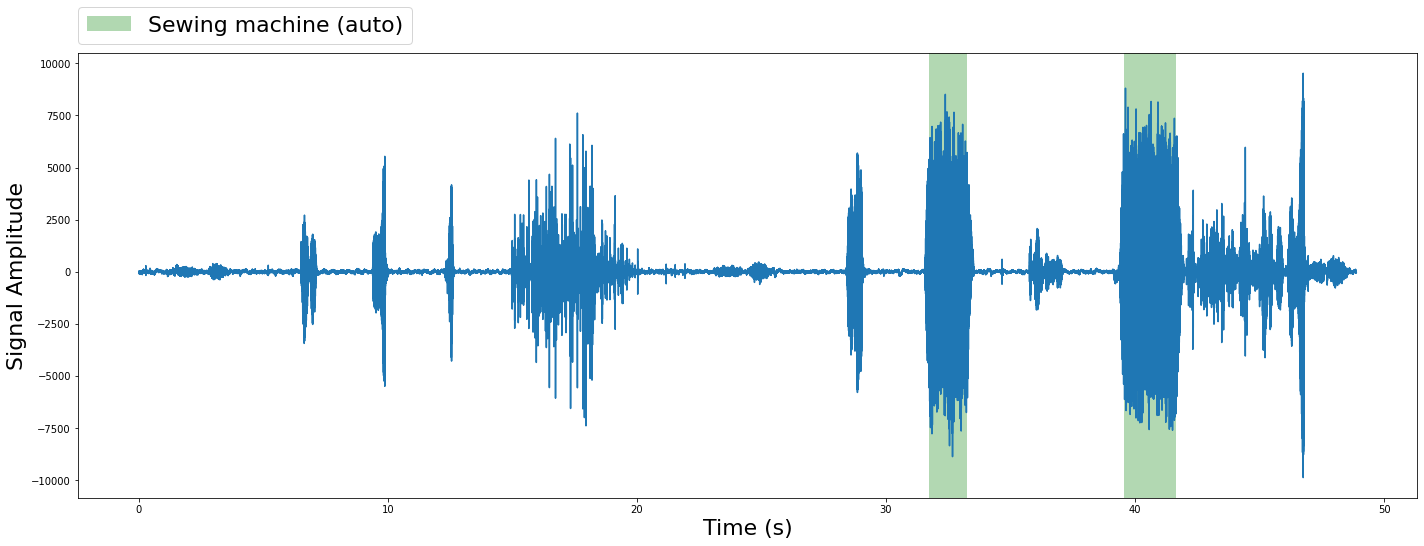

In [29]:
tokenizer = StreamTokenizer(validator=speech_validator, min_length= int(0.5 * analysis_window_per_second),
                                max_length=int(15 * analysis_window_per_second),
                                max_continuous_silence= 0.3 * analysis_window_per_second,
                                mode = StreamTokenizer.DROP_TRAILING_SILENCE)
tokenizer.validator = sewing_machine_validator
mfcc_data_source.rewind()
mfcc_data_source.scope = 0
tokens = tokenizer.tokenize(mfcc_data_source)
ts = [(t[1] * ANALYSIS_STEP, t[2] * ANALYSIS_STEP) for t in tokens]

seg = {"fc" : "g", "ec" : "g", "lw" : 0, "alpha" : 0.3, "title" : "Sewing machine (auto)", "timestamps" : ts}

plot_signal_and_segmentation(signal, SAMPLING_RATE, [seg])

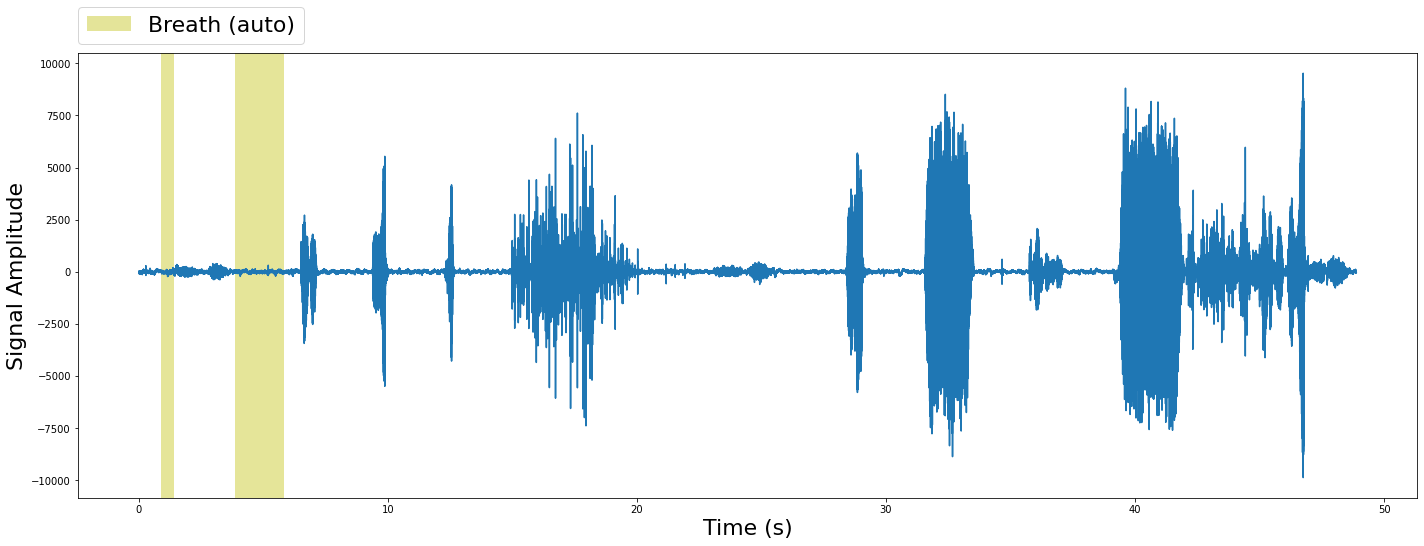

In [33]:
tokenizer.validator = breath_validator
mfcc_data_source.rewind()
mfcc_data_source.scope = 0
tokens = tokenizer.tokenize(mfcc_data_source)
ts = [(t[1] * ANALYSIS_STEP, t[2] * ANALYSIS_STEP) for t in tokens]
seg = {"fc" : "y", "ec" : "y", "lw" : 0, "alpha" : 0.4, "title" : "Breath (auto)", "timestamps" : ts}
plot_signal_and_segmentation(signal, SAMPLING_RATE, [seg])